In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357283 sha256=383b2cc498c5349fb04de177bfdf75b1c08244a92e55030ff7d9801c79154c4e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Load the fashion dataset
file_path = 'fashion_dataset.csv'
fashion_data = pd.read_csv(file_path)

In [ ]:
fashion_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,...,link,ratings,review,Month,Price (USD),user_id1,user_id2,user_id3,user_id4,user_id5
0,8493,Women,Apparel,Bottomwear,Skirts,Black,Fall,2011.0,Casual,Forever New Women Black Skirts,...,http://assets.myntassets.com/v1/images/style/p...,5,Amazing quality! Definitely recommend. Would r...,November,46,93810,67912,12506,31747,17972
1,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,Fabindia Men Grey Mangalgiri Kurta,...,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy..",September,29,24592,54541,98358,62538,23573
2,14881,Women,Accessories,Bags,Handbags,Black,Summer,2011.0,Casual,United Colors of Benetton Women Solid Black Ha...,...,http://assets.myntassets.com/v1/images/style/p...,3,"It's okay, nothing special.!",October,39,13278,34966,71797,93928,90931
3,48449,Men,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,French Connection Men Blue T-shirt,...,http://assets.myntassets.com/v1/images/style/p...,5,"Comfortable and stylish, worth the price. and ...",August,39,46048,40972,76426,52622,68556
4,4697,Unisex,Accessories,Watches,Watches,Black,Winter,2016.0,Sports,ADIDAS Unisex Digital Duramo Black Watch,...,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy.!",March,33,42098,58790,98835,49226,67898


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.accuracy import rmse
from PIL import Image
from IPython.display import display

# Melt and prepare user-item matrix
user_columns = ['user_id1', 'user_id2', 'user_id3', 'user_id4', 'user_id5']
melted_data = fashion_data.melt(
    id_vars=['id', 'ratings', 'filename', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'Price (USD)'],
    value_vars=user_columns, var_name='user_column', value_name='user_id'
).drop(columns=['user_column']).dropna()

# Prepare the data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(melted_data[['user_id', 'id', 'ratings']], reader)


In [ ]:
from surprise.model_selection import RandomizedSearchCV

# Smaller parameter distribution for quicker tuning
param_dist = {'n_factors': [50, 100, 150], 'lr_all': [0.003, 0.005, 0.007], 'reg_all': [0.01, 0.02, 0.03], 'n_epochs': [20, 30]}


# Use RandomizedSearchCV for faster tuning
rs = RandomizedSearchCV(SVD, param_dist, measures=['rmse'], cv=3, n_iter=4)  # n_iter limits the number of samples
rs.fit(data)

# Get the best SVD model and print RMSE
best_svd = rs.best_estimator['rmse']
print("Best RMSE:", rs.best_score['rmse'])
print("Best Params:", rs.best_params['rmse'])

Best RMSE: 0.8526632695892186
Best Params: {'n_factors': 50, 'lr_all': 0.007, 'reg_all': 0.01, 'n_epochs': 30}


In [ ]:
# Get the best SVD model and print RMSE
best_svd = rs.best_estimator['rmse']
print("Best RMSE:", rs.best_score['rmse'])
print("Best Params:", rs.best_params['rmse'])

Best RMSE: 0.8526632695892186
Best Params: {'n_factors': 50, 'lr_all': 0.007, 'reg_all': 0.01, 'n_epochs': 30}


In [ ]:

# Fit the best model on the full training data
best_svd.fit(data.build_full_trainset())

In [ ]:
# Define complementary items with diverse categories
complementary_mapping = {
    'Skirts': ['Tshirts', 'Watches', 'Handbags', 'Heels'],
    'Tshirts': ['Jeans', 'Belts', 'Casual Shoes', 'Backpacks'],
    'Jeans': ['Shirts', 'Belts', 'Watches', 'Casual Shoes'],
    'Dresses': ['Heels', 'Clutches', 'Earrings', 'Watches'],
    'Shirts': ['Trousers', 'Formal Shoes', 'Belts', 'Watches'],
    'Kurtas': ['Leggings', 'Dupatta', 'Earrings', 'Sandals','Watches','Formal Shoes'],
    'Handbags': ['Tshirts', 'Jeans', 'Watches', 'Heels'],
    'Formal Shoes': ['Shirts', 'Trousers', 'Belts', 'Watches'],
    'Flip Flops': ['Shorts', 'Tshirts', 'Sunglasses'],
    'Heels': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Leggings': ['Tops', 'Kurtas', 'Dupatta', 'Sandals'],
    'Backpacks': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Earrings': ['Dresses', 'Clutches', 'Heels', 'Watches'],
    'Clutches': ['Heels', 'Dresses', 'Earrings', 'Necklace and Chains'],
    'Casual Shoes': ['Jeans', 'Tshirts', 'Belts', 'Backpacks'],
    'Dupatta': ['Kurtas', 'Leggings', 'Sandals', 'Earrings'],
    'Tops': ['Skirts', 'Watches', 'Handbags', 'Heels'],
    'Ring': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Flats': ['Shorts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suspenders': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Sports Shoes': ['Track Pants', 'Tshirts', 'Watches', 'Backpacks'],
    'Sunglasses': ['Tshirts', 'Jeans', 'Casual Shoes', 'Backpacks'],
    'Shorts': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Belts': ['Jeans', 'Tshirts', 'Casual Shoes', 'Watches'],
    'Sarees': ['Handbags','Earrings', 'Necklace and Chains', 'Heels','Watches'],
    'Nightdress': ['Lounge Pants', 'Robe', 'Socks', 'Slippers'],
    'Jackets': ['Jeans', 'Tshirts', 'Sneakers', 'Backpacks'],
    'Trousers': ['Shirts', 'Formal Shoes', 'Belts', 'Watches'],
    'Messenger Bag': ['Tshirts', 'Jeans', 'Casual Shoes', 'Sunglasses'],
    'Track Pants': ['Sports Shoes', 'Tshirts', 'Watches', 'Backpacks'],
    'Kurtis': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Capris': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Sweatshirts': ['Jeans', 'Sneakers', 'Backpacks', 'Watches'],
    'Wallets': ['Jeans', 'Shirts', 'Belts', 'Watches','Trousers'],
    'Socks': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Backpacks'],
    'Necklace and Chains': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Stockings': ['Skirts', 'Heels', 'Handbags', 'Tops'],
    'Waist Pouch': ['Tshirts', 'Shorts', 'Sunglasses', 'Sneakers'],
    'Tunics': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Booties': ['Dresses', 'Leggings', 'Clutches', 'Necklace and Chains'],
    'Lounge Pants': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    'Sweaters': ['Jeans', 'Boots', 'Backpacks', 'Watches'],
    'Pendant': ['Tshirts', 'Jeans', 'Watches', 'Dresses','Necklace and Chains', 'Clutches'],
    'Duffel Bag': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Watches'],
    'Tracksuits': ['Sports Shoes', 'Duffel Bag', 'Watches', 'Socks'],
    'Baby Dolls': ['Robes', 'Slippers', 'Socks', 'Nightgowns'],
    'Laptop Bag': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Night suits': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Tights': ['Tunics', 'Sweatshirts', 'Sneakers', 'Backpacks'],
    'Jeggings': ['Tops', 'Heels', 'Handbags', 'Sunglasses'],
    'Mobile Pouch': ['Jeans', 'Tshirts', 'Casual Shoes', 'Belts'],
    'Jewellery Set': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Lounge Shorts': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    #'Swimwear': ['Sunglasses', 'Flip Flops', 'Beach Bags'],
    'Swimwear': ['Sunglasses', 'Swimwear', 'Beach Bags'],
    'Bangle': ['Sarees', 'Necklace and Chains', 'Earrings', 'Sandals'],
    'Churidar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Salwar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Shrug': ['Tops', 'Jeans', 'Sneakers', 'Backpacks'],
    'Bracelet': ['Shirts','Jeans','Casual Shoes','Belts','Dresses', 'Necklace and Chains', 'Earrings', 'Watches'],
    'Waistcoat': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Rucksacks': ['Tshirts', 'Jeans', 'Sneakers', 'Sunglasses'],
    'Blazers': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Rompers': ['Sandals', 'Clutches', 'Earrings', 'Watches'],
    'Robe': ['Nightdress', 'Slippers', 'Socks', 'Night Tshirts'],
    'Salwar and Dupatta': ['Kurtas', 'Sandals', 'Earrings', 'Bangles'],
    'Tablet Sleeve': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Rain Jacket': ['Track Pants', 'Sports Shoes', 'Backpacks'],
    'Lounge Tshirts': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Lehenga Choli': ['Earrings', 'Necklace and Chains', 'Bangles', 'Sandals'],
    'Sandals': ['Skirts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suits': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Travel Accessory': ['Backpacks', 'Sneakers', 'Sunglasses'],
    'Trolley Bag': ['Casual Shoes', 'Jeans', 'Tshirts', 'Watches'],
    'Watches' : ['Shirts', 'Jeans', 'Tshirts', 'Shoes'],
    'Bangle' : ['Saree', 'Dresses', 'Necklace and Chains', 'Earrings']
}



Recommendations for User ID 93810 based on input articleType: Skirts (Gender: Women)
Input Item:


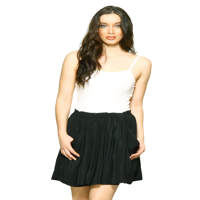

Item ID: 9823, Gender: Women, Price: 53, Category: Apparel, Subcategory: Topwear


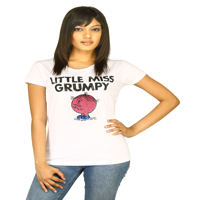

Item ID: 44985, Gender: Women, Price: 50, Category: Accessories, Subcategory: Watches


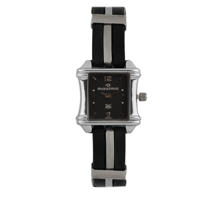

Item ID: 35148, Gender: Women, Price: 58, Category: Accessories, Subcategory: Bags


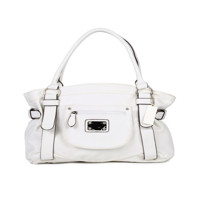

Item ID: 21042, Gender: Women, Price: 43, Category: Footwear, Subcategory: Shoes


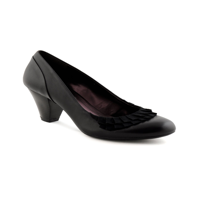

In [ ]:
#19-11-24
import pandas as pd
from PIL import Image
from IPython.display import display
from surprise import SVD

# Function to display complete wear recommendations with unique article types
def display_complete_wear_recommendations(user_id, svd_model, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200)):
    # Get the gender of the target user
    user_data = fashion_data[fashion_data['user_id1'] == user_id]
    if user_data.empty:
        print(f"No data found for user ID: {user_id}")
        return

    target_user_gender = user_data['gender'].iloc[0]

    # Filter the dataset by gender
    gender_filtered_data = fashion_data[fashion_data['gender'] == target_user_gender]

    # Get the input item associated with the user
    input_item = user_data.iloc[0]
    input_article_type = input_item['articleType']

    # Get complementary categories for the input articleType
    complementary_categories = complementary_mapping.get(input_article_type, [])

    if not complementary_categories:
        print(f"No complementary items defined for {input_article_type}.")
        return

    print(f"Recommendations for User ID {user_id} based on input articleType: {input_article_type} (Gender: {target_user_gender})")

    # Display input item image
    try:
        input_image_path = f"/content/drive/MyDrive/Images/{input_item['filename']}"
        input_image = Image.open(input_image_path).resize(img_size)
        print("Input Item:")
        display(input_image)
    except Exception as e:
        print(f"Could not display input item image. Error: {e}")

    # Initialize a list to store recommendations
    recommendations = []

    for category in complementary_categories:
        # Filter the dataset for items matching the current complementary category
        category_items = gender_filtered_data[gender_filtered_data['articleType'] == category]

        if not category_items.empty:
            # Use SVD model to predict ratings for items in this category
            category_recommendations = [
                (item, svd_model.predict(user_id, item['id']).est)
                for _, item in category_items.iterrows()
            ]

            # Select the top-rated item in the category
            if category_recommendations:
                best_item = max(category_recommendations, key=lambda x: x[1])[0]
                recommendations.append(best_item)

    # Display the recommended items
    for item in recommendations:
        try:
            image_path = f"/content/drive/MyDrive/Images/{item['filename']}"
            img = Image.open(image_path).resize(img_size)
            print(
                f"Item ID: {item['id']}, Gender: {item['gender']}, Price: {item['Price (USD)']}, "
                f"Category: {item['masterCategory']}, Subcategory: {item['subCategory']}"
            )
            display(img)
        except Exception as e:
            print(f"Could not display image for Item ID {item['id']}. Error: {e}")
'''
# Example function to simulate SVD-based recommendations
def get_svd_recommendations(user_id, svd_model, valid_items, top_n=5):
    recommendations = []
    for _, item in valid_items.iterrows():
        item_id = item['id']
        est_rating = svd_model.predict(user_id, item_id).est
        recommendations.append((item, est_rating))

    # Sort by predicted rating and return the top N
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    return pd.DataFrame([rec[0] for rec in recommendations[:top_n]])
'''
# Example usage
user_id = 93810  # Example user ID
display_complete_wear_recommendations(user_id, best_svd, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200))


Recommendations for User ID 28301 based on input articleType: Sarees (Gender: Women)
Input Item:


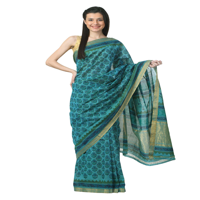

Item ID: 21536, Gender: Women, Price: 32, Category: Accessories, Subcategory: Bags


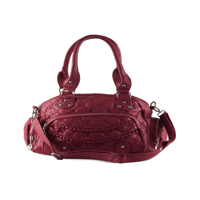

Item ID: 48621, Gender: Women, Price: 39, Category: Accessories, Subcategory: Jewellery


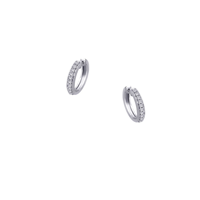

Item ID: 52310, Gender: Women, Price: 59, Category: Accessories, Subcategory: Jewellery


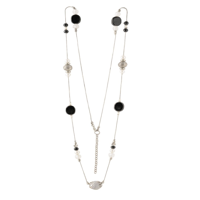

Item ID: 22289, Gender: Women, Price: 37, Category: Footwear, Subcategory: Shoes


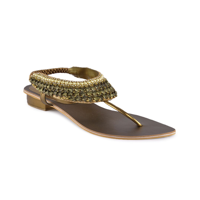

Item ID: 29493, Gender: Women, Price: 43, Category: Accessories, Subcategory: Watches


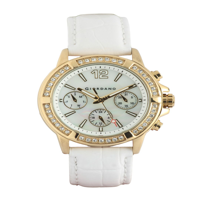

In [ ]:
# Example usage
user_id = 28301  # Example user ID
display_complete_wear_recommendations(user_id, best_svd, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200))

Recommendations for User ID 51347 based on input articleType: Track Pants (Gender: Men)
Input Item:


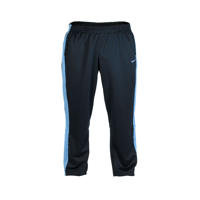

Item ID: 29262, Gender: Men, Price: 48, Category: Footwear, Subcategory: Shoes


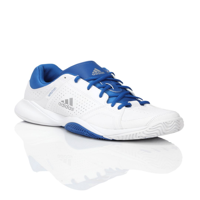

Item ID: 16641, Gender: Men, Price: 42, Category: Apparel, Subcategory: Topwear


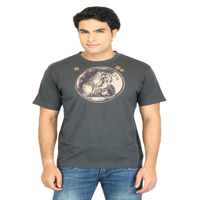

Item ID: 46529, Gender: Men, Price: 47, Category: Accessories, Subcategory: Watches


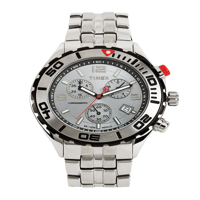

Item ID: 20938, Gender: Men, Price: 60, Category: Accessories, Subcategory: Bags


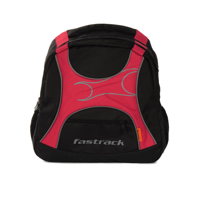

In [ ]:
# Example usage
user_id = 51347  # Example user ID
display_complete_wear_recommendations(user_id, best_svd, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200))

Recommendations for User ID 95181 based on input articleType: Watches (Gender: Men)
Input Item:


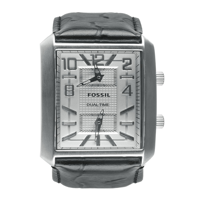

Item ID: 17157, Gender: Men, Price: 35, Category: Apparel, Subcategory: Topwear


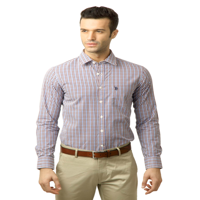

Item ID: 30102, Gender: Men, Price: 56, Category: Apparel, Subcategory: Bottomwear


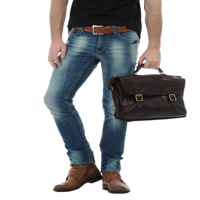

Item ID: 4367, Gender: Men, Price: 42, Category: Apparel, Subcategory: Topwear


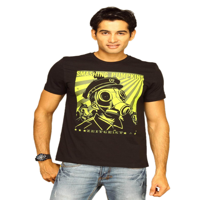

In [ ]:
# Example usage:
user_id = 95181  # Example user_id to test the recommendation and image display
display_complete_wear_recommendations(user_id, best_svd, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200))

Recommendations for User ID 24592 based on input articleType: Kurtas (Gender: Men)
Input Item:


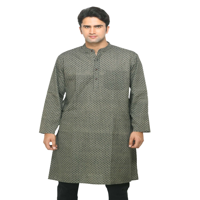

Item ID: 10303, Gender: Men, Price: 59, Category: Footwear, Subcategory: Shoes


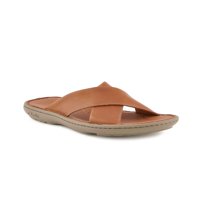

Item ID: 41035, Gender: Men, Price: 60, Category: Accessories, Subcategory: Watches


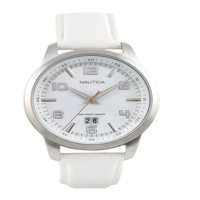

Item ID: 6507, Gender: Men, Price: 55, Category: Footwear, Subcategory: Shoes


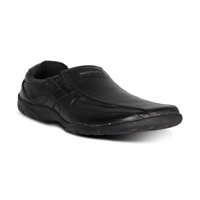

In [ ]:
# Example usage:
user_id = 24592  # Example user_id to test the recommendation and image display
display_complete_wear_recommendations(user_id, best_svd, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200))

In [ ]:
#evaluation

In [ ]:
from surprise.model_selection import train_test_split

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


In [ ]:
best_svd.fit(trainset)


In [ ]:
# Test the model
predictions = best_svd.test(testset)


In [ ]:
# Define the precision_recall_at_k function (as provided in the earlier response)
from collections import defaultdict

def precision_recall_at_k(predictions, k=5, threshold=4.0):
    """Return precision and recall at k metrics."""
    # Map the predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top-K
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top-K
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K and Recall@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Average precision and recall
    precision = sum(precisions.values()) / len(precisions)
    recall = sum(recalls.values()) / len(recalls)

    return precision, recall

# Calculate precision and recall
precision, recall = precision_recall_at_k(predictions, k=5, threshold=4.0)

# Print results
print(f"Precision@K: {precision}")
print(f"Recall@K: {recall}")


Precision@K: 0.8257342896174863
Recall@K: 0.44010048865069384


In [ ]:
from surprise import accuracy

# Accuracy Metrics
# Compute RMSE and MAE
rmse = accuracy.rmse(predictions, verbose=True)
mae = accuracy.mae(predictions, verbose=True)



# F1 Score Calculation
def f1_score(precision, recall):
    """
    Calculates the F1 Score using Precision and Recall.
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    """
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

# Compute F1 Score
f1 = f1_score(precision, recall)
print(f"F1 Score: {f1:.2f}")


RMSE: 0.7791
MAE:  0.6336
F1 Score: 0.57


In [ ]:
#svd&pmf
import pandas as pd

# Load your dataset
file_path = 'fashion_dataset.csv' # Replace with your dataset's path
fashion_data = pd.read_csv(file_path)

# Reshape data for user-item interaction matrix creation
interaction_columns = ['user_id1', 'user_id2', 'user_id3', 'user_id4', 'user_id5']
interaction_data = fashion_data.melt(id_vars=['id'],
                                     value_vars=interaction_columns,
                                     var_name='interaction_type',
                                     value_name='user_id').dropna()

# Aggregate interactions by user_id and item_id
interaction_data = interaction_data[['user_id', 'id']].drop_duplicates()
interaction_data['interaction'] = 1  # Assign a default interaction weight

# Create a user-item interaction matrix
interaction_matrix = interaction_data.pivot(index='user_id', columns='id', values='interaction').fillna(0)

print("Interaction Matrix Shape:", interaction_matrix.shape)


Interaction Matrix Shape: (4891, 36484)


In [ ]:
from scipy.sparse.linalg import svds
import numpy as np

# Convert interaction matrix to a numpy array
interaction_matrix_array = interaction_matrix.values

# Perform SVD
U, sigma, Vt = svds(interaction_matrix_array, k=50)  # k = number of latent factors
sigma = np.diag(sigma)  # Convert sigma into a diagonal matrix

# Reconstruct the interaction matrix
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert predictions back to a DataFrame
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=interaction_matrix.index, columns=interaction_matrix.columns)
'''
# Function to recommend items for a given user
def recommend_items_svd(user_id, num_recommendations=5):
    user_row = predicted_ratings_df.loc[user_id]
    # Filter out already interacted items
    interacted_items = interaction_matrix.loc[user_id]
    recommendations = user_row[interacted_items == 0].nlargest(num_recommendations)
    return recommendations
'''

'\n# Function to recommend items for a given user\ndef recommend_items_svd(user_id, num_recommendations=5):\n    user_row = predicted_ratings_df.loc[user_id]\n    # Filter out already interacted items\n    interacted_items = interaction_matrix.loc[user_id]\n    recommendations = user_row[interacted_items == 0].nlargest(num_recommendations)\n    return recommendations\n'

In [ ]:
!pip install lightfm

In [ ]:
from lightfm import LightFM
from scipy.sparse import csr_matrix

# Prepare the sparse matrix
interaction_matrix_sparse = csr_matrix(interaction_matrix.values)

# Define the PMF model
pmf_model = LightFM(loss='warp', no_components=50)  # 50 latent dimensions (tunable)

# Train the PMF model
pmf_model.fit(interaction_matrix_sparse, epochs=10, num_threads=4)

# Save the trained model
print("PMF model trained successfully!")


PMF model trained successfully!


In [ ]:
def recommend_items_with_complementary_mapping(
    model, user_id, item_id, num_recommendations=5
):
    # Ensure user and item exist
    if user_id not in interaction_matrix.index:
        return f"User {user_id} not found in the interaction matrix."
    if item_id not in fashion_data['id'].values:
        return f"Item {item_id} not found in the dataset."

    # Get user embedding
    user_idx = interaction_matrix.index.get_loc(user_id)
    user_embedding = model.user_embeddings[user_idx]

    # Input item details
    input_item = fashion_data[fashion_data['id'] == item_id].iloc[0]
    input_gender = input_item['gender']
    input_article_type = input_item['articleType']

    # Get complementary item types from the mapping
    complementary_items = complementary_mapping.get(input_article_type, [])
    if not complementary_items:
        return f"No complementary items defined for articleType: {input_article_type}"

    # Filter dataset for complementary items
    filtered_items = fashion_data[
        (fashion_data['articleType'].isin(complementary_items)) &
        (fashion_data['gender'] == input_gender)  # Match gender
    ]

    # Exclude the input item from recommendations
    filtered_items = filtered_items[filtered_items['id'] != item_id]

    # Calculate scores for remaining items
    item_indices = filtered_items.index
    item_embeddings = model.item_embeddings[item_indices]
    scores = user_embedding @ item_embeddings.T

    # Rank items by score
    filtered_items['score'] = scores
    ranked_items = filtered_items.sort_values(by='score', ascending=False)

    # Ensure unique articleType in recommendations
    unique_recommendations = ranked_items.drop_duplicates(subset='articleType').head(num_recommendations)

    # Return input item and final recommendations
    return input_item, unique_recommendations[['id', 'gender', 'articleType', 'subCategory']]


In [ ]:
user_id = 93810
item_id = 8493  # Input item_id

# Call the function to get recommendations
result = recommend_items_with_complementary_mapping(pmf_model, user_id, item_id, num_recommendations=5)

if isinstance(result, str):  # If an error message is returned
    print(result)
else:
    input_item_details, recommendations = result

    # Display input item details
    print(f"Input item details:\n{input_item_details[['id', 'gender', 'articleType', 'subCategory']]}")

    # Display top 5 recommendations
    print(f"\nTop recommendations for user {user_id} based on item {item_id}:")
    print(recommendations)

Input item details:
id                   8493
gender              Women
articleType        Skirts
subCategory    Bottomwear
Name: 0, dtype: object

Top recommendations for user 93810 based on item 8493:
          id gender articleType subCategory
36398   5174  Women     Tshirts     Topwear
13755  50151  Women       Heels       Shoes
27738  43334  Women    Handbags        Bags
31115  26350  Women     Watches     Watches


In [ ]:
user_id = 31747
item_id = 59622  # Input item_id

# Call the function to get recommendations
result = recommend_items_with_complementary_mapping(pmf_model, user_id, item_id, num_recommendations=5)

if isinstance(result, str):  # If an error message is returned
    print(result)
else:
    input_item_details, recommendations = result

    # Display input item details
    print(f"Input item details:\n{input_item_details[['id', 'gender', 'articleType', 'subCategory']]}")

    # Display top 5 recommendations
    print(f"\nTop recommendations for user {user_id} based on item {item_id}:")
    print(recommendations)

Input item details:
id              59622
gender          Women
articleType    Sarees
subCategory     Saree
Name: 226, dtype: object

Top recommendations for user 31747 based on item 59622:
          id gender          articleType subCategory
14466  43829  Women             Earrings   Jewellery
28850  46126  Women  Necklace and Chains   Jewellery
19839  22255  Women                Heels       Shoes
31315  32305  Women              Watches     Watches
28912  20449  Women             Handbags        Bags
